In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
def read_metrics_csv(dataset, method):
    df = pd.read_csv(f"results/{dataset}/{method}_metrics.csv")
    runs = [group for _, group in df.groupby("run_id")]
    return runs


In [28]:
def read_summaries(dataset, method, stage):
    df = pd.read_csv(f"results/{dataset}/{stage}/{method}_summaries.csv")
    summaries = [group for _, group in df.groupby("run_id")]
    return summaries



In [29]:
def read_summaries(dataset, method, stage):
    df = pd.read_csv(f"results/{dataset}/{stage}/{method}_summaries.csv")
    df["method"] = method  # Add a column to indicate the method
    df["dataset"] = dataset  # Add a column to indicate the dataset
    return df

# List of methods
methods = ["regular", "regular-decorr", "vibcreg", "vibcreg-decorr", "barlowtwins", "barlowtwins-decorr", "byol", "byol-decorr"]

datasets = [
    "ElectricDevices",
    "StarLightCurves",
    "Wafer",
    "ECG5000",
    "TwoPatterns",
    "FordA",
    "UWaveGestureLibraryAll",
    "FordB",
    "ChlorineConcentration",
    "ShapesAll",
]

# Read the summaries for all methods and all datasets into a single DataFrame
all_summaries_stage1 = pd.concat([read_summaries(dataset, method, "stage1") for dataset in datasets for method in methods])
all_summaries_stage2 = pd.concat([read_summaries(dataset, method, "stage2") for dataset in datasets for method in methods])

In [36]:
# For all_summaries_stage1
max_svm_accuracy_index = all_summaries_stage1.groupby(['dataset', 'method'])['svm_accuracy'].idxmax()
max_knn_accuracy_index = all_summaries_stage1.groupby(['dataset', 'method'])['knn_accuracy'].idxmax()

best_svm_accuracy_values = all_summaries_stage1.loc[max_svm_accuracy_index]
best_knn_accuracy_values = all_summaries_stage1.loc[max_knn_accuracy_index]

# For all_summaries_stage2
max_is_mean_index = all_summaries_stage2.groupby(['dataset', 'method'])['IS_mean'].idxmax()
min_fid_index = all_summaries_stage2.groupby(['dataset', 'method'])['FID'].idxmin()

best_is_mean_values = all_summaries_stage2.loc[max_is_mean_index]
best_fid_values = all_summaries_stage2.loc[min_fid_index]

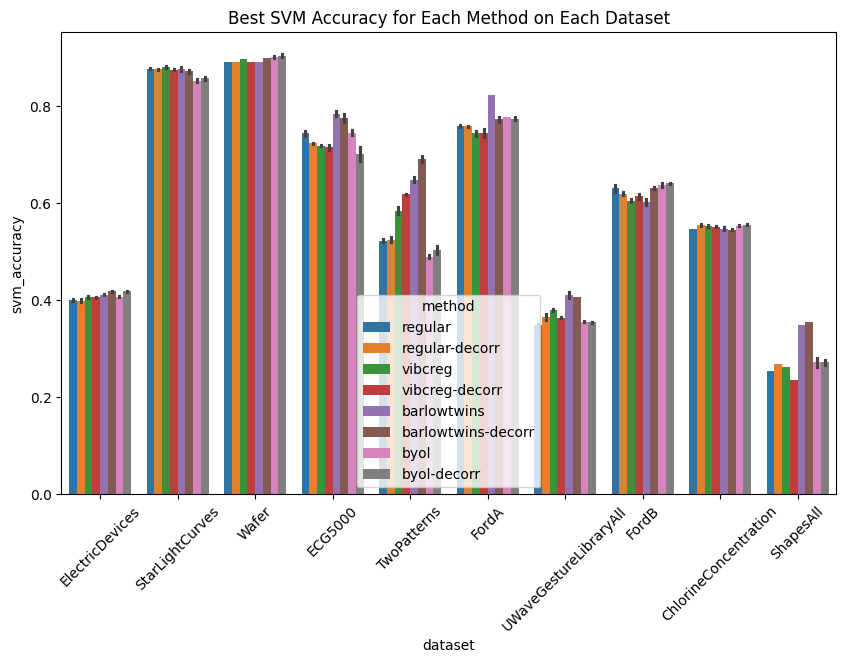

In [37]:
plt.figure(figsize=(10, 6))
sns.barplot(x="dataset", y="svm_accuracy", hue="method", data=best_svm_accuracy_values)
plt.title("Best SVM Accuracy for Each Method on Each Dataset")
plt.xticks(rotation=45)
plt.show()

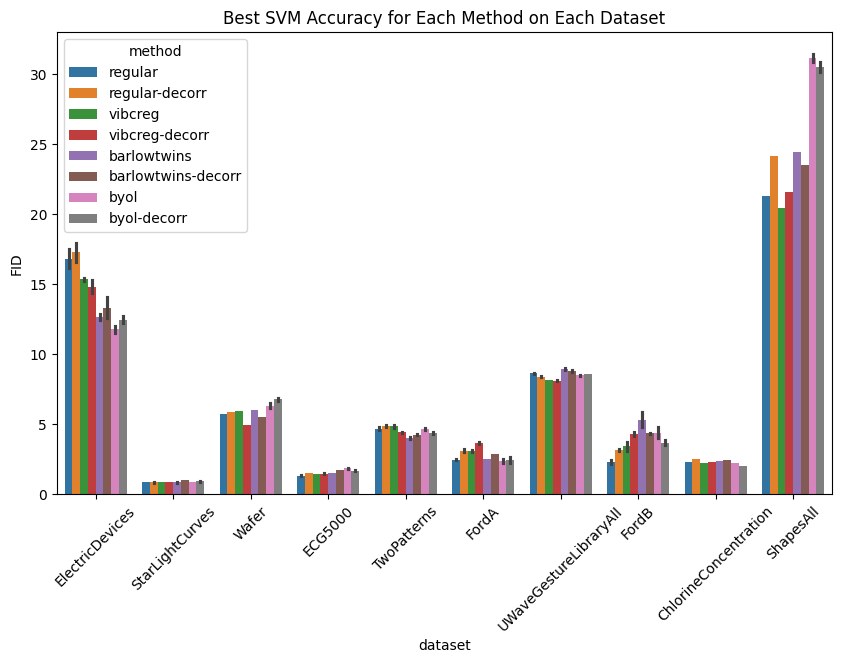

In [38]:
plt.figure(figsize=(10, 6))
sns.barplot(x="dataset", y="FID", hue="method", data=best_fid_values)
plt.title("Best FID score for Each Method on Each Dataset")
plt.xticks(rotation=45)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x="dataset", y="svm_accuracy", hue="method", data=best_svm_accuracy_values)
plt.title("Best SVM Accuracy for Each Method on Each Dataset")
plt.xticks(rotation=45)
plt.show()

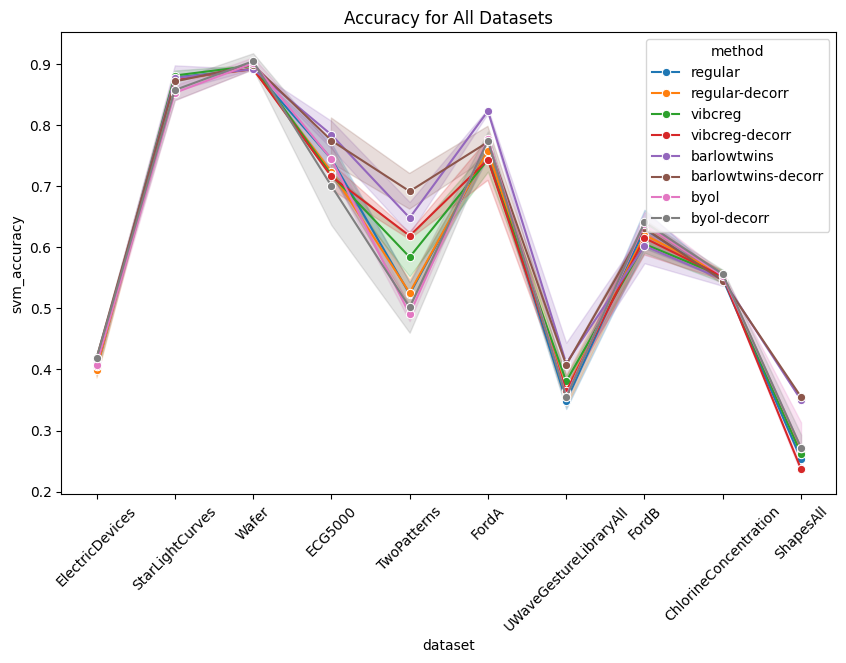

In [30]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="dataset", y="svm_accuracy", hue="method", data=all_summaries_stage1, marker='o')
plt.title("Accuracy for All Datasets")
plt.xticks(rotation=45)
plt.show()

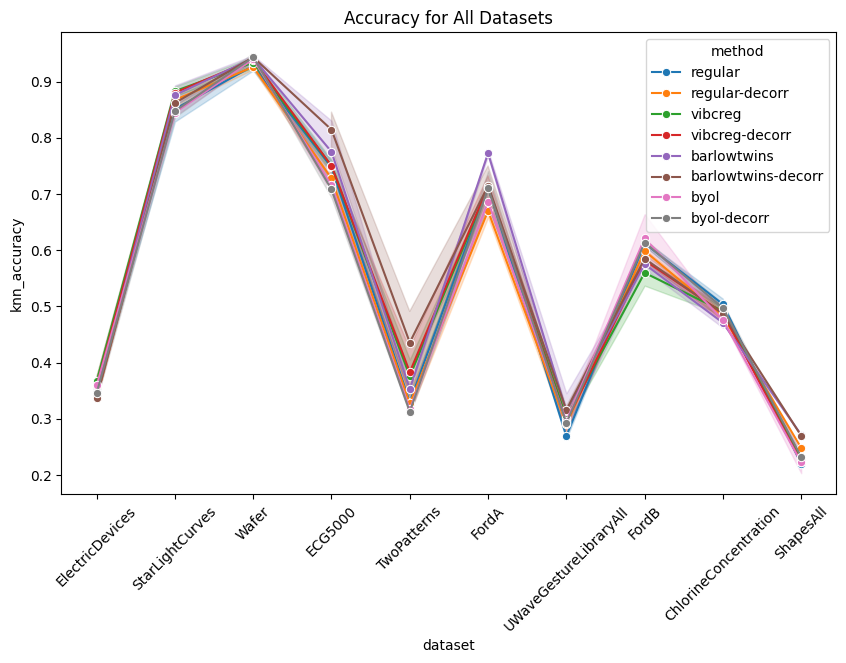

In [31]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="dataset", y="knn_accuracy", hue="method", data=all_summaries_stage1, marker='o')
plt.title("Accuracy for All Datasets")
plt.xticks(rotation=45)
plt.show()

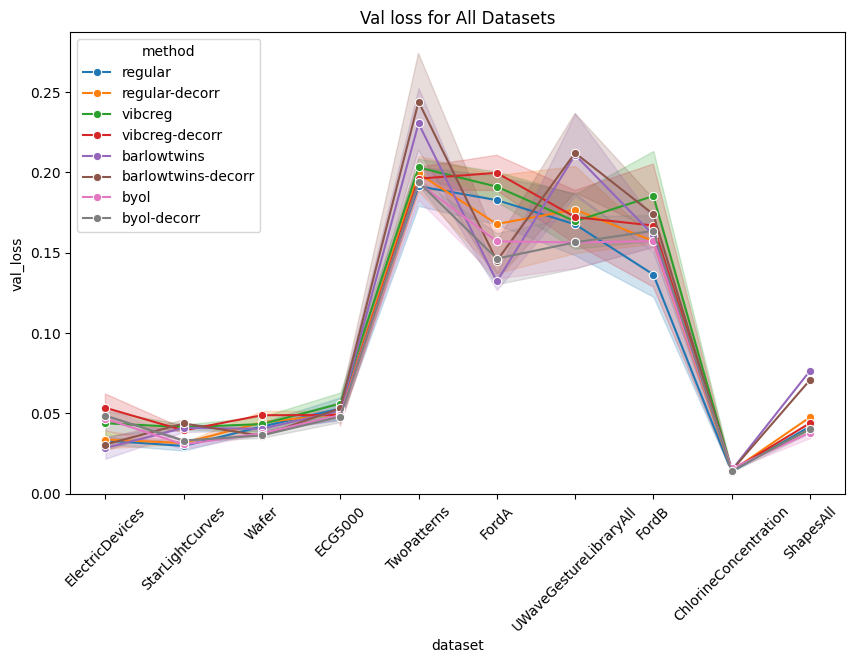

In [32]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="dataset", y="val_loss", hue="method", data=all_summaries_stage1, marker='o')
plt.title("Val loss for All Datasets")
plt.xticks(rotation=45)
plt.show()

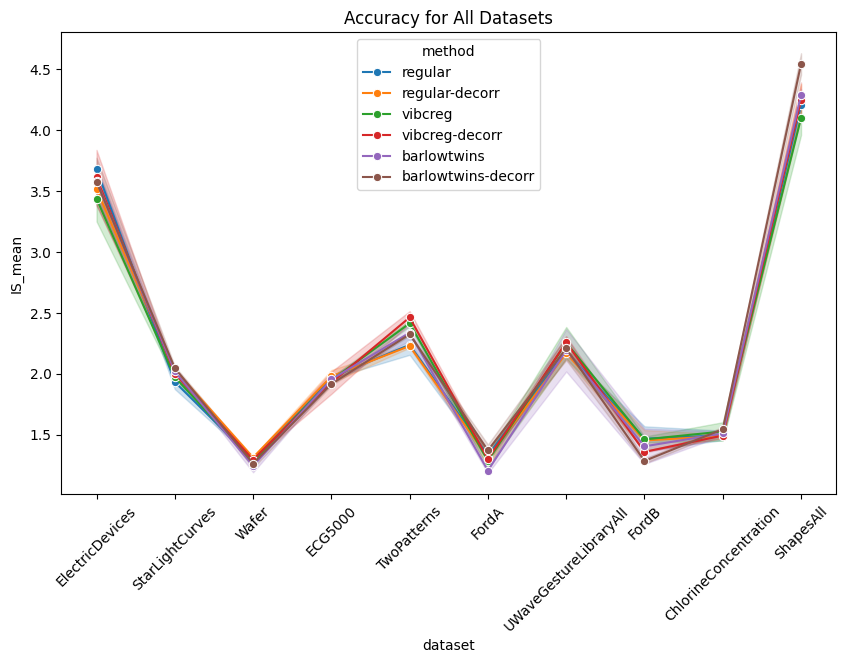

In [18]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="dataset", y="IS_mean", hue="method", data=all_summaries_stage2, marker='o')
plt.title("IS for All Datasets")
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_66701/2238153706.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a[datasets.index(dataset)][0].set_xticklabels(a[datasets.index(dataset)][0].get_xticklabels(), rotation=45)  # Rotate x-axis labels
/tmp/ipykernel_66701/2238153706.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a[datasets.index(dataset)][1].set_xticklabels(a[datasets.index(dataset)][1].get_xticklabels(), rotation=45)  # Rotate x-axis labels
/tmp/ipykernel_66701/2238153706.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a[datasets.index(dataset)][0].set_xticklabels(a[datasets.index(dataset)][0].get_xticklabels(), rotation=45)  # Rotate x-axis labels
/tmp/ipykernel_66701/2238153706.py:8: UserWarning: set_ticklabels() should only be used with a fixed

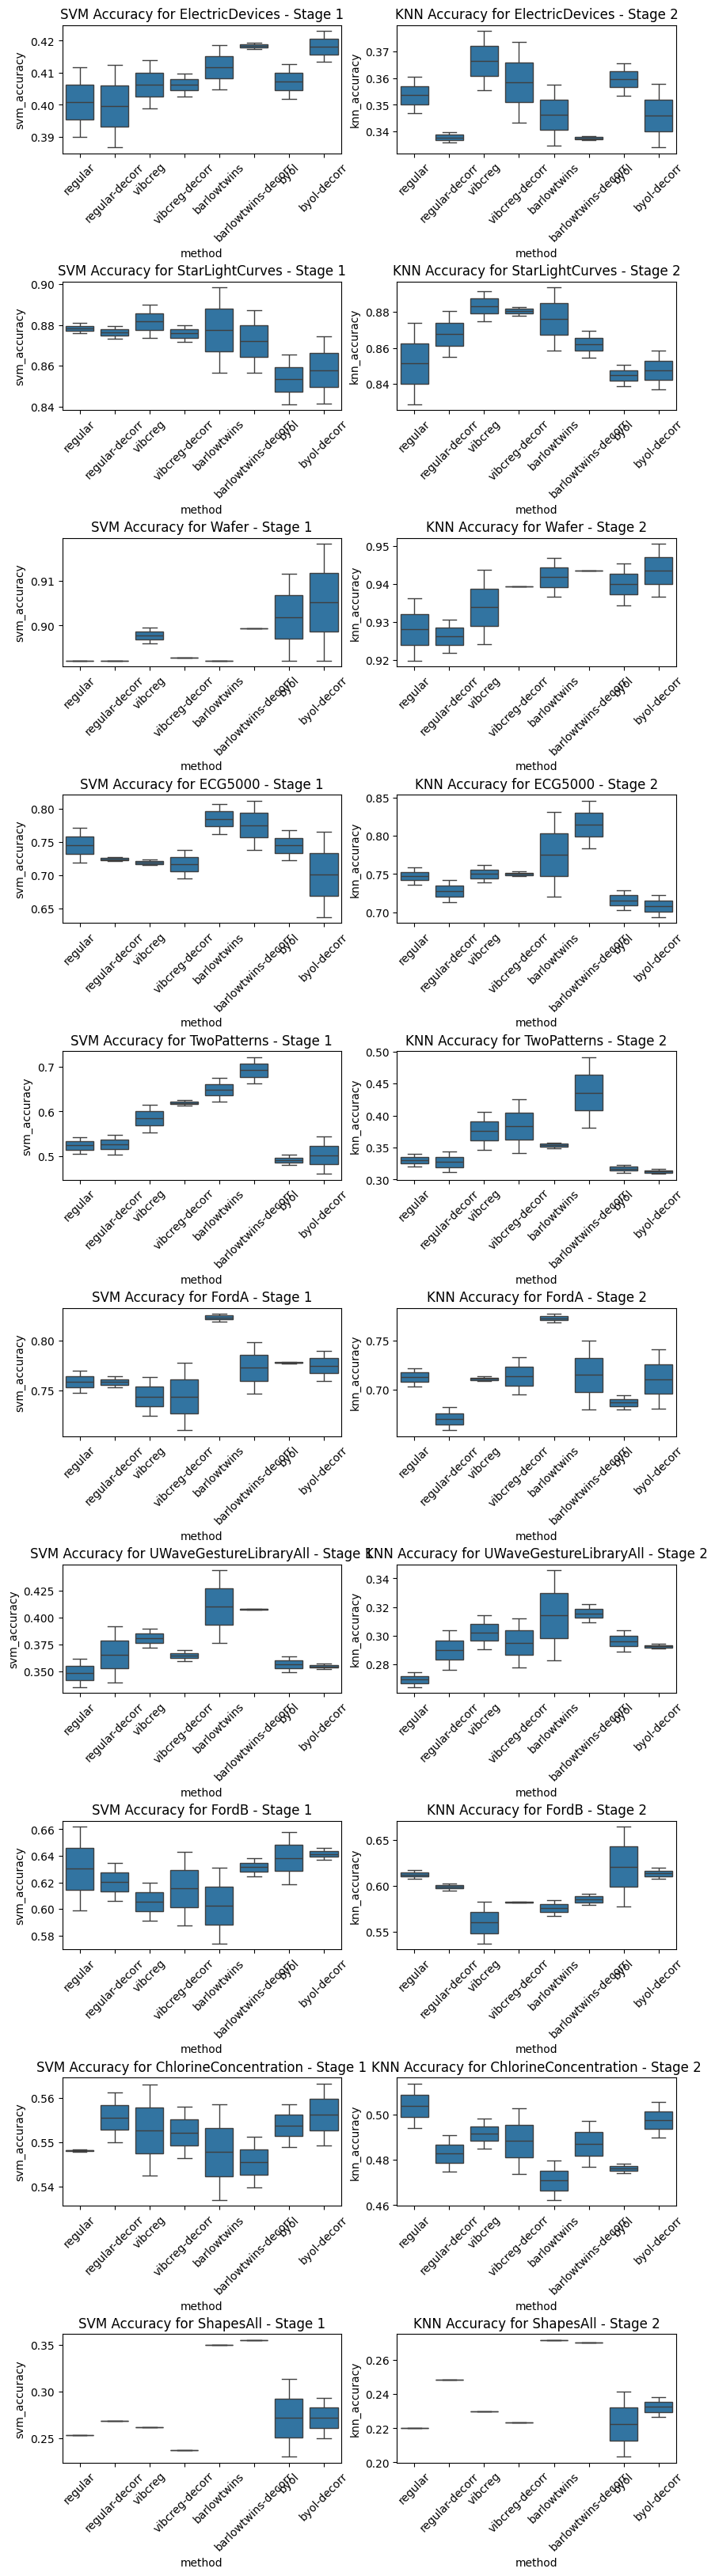

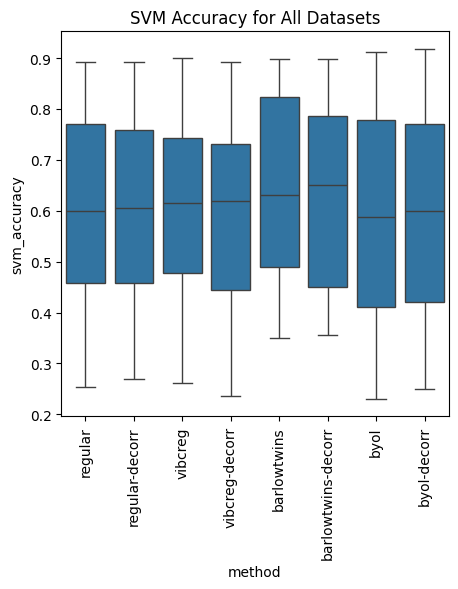

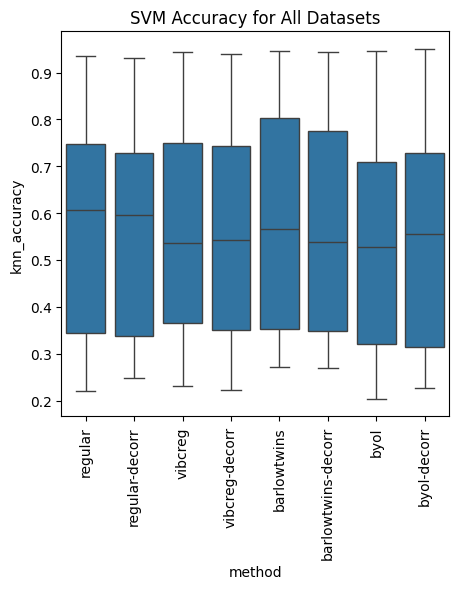

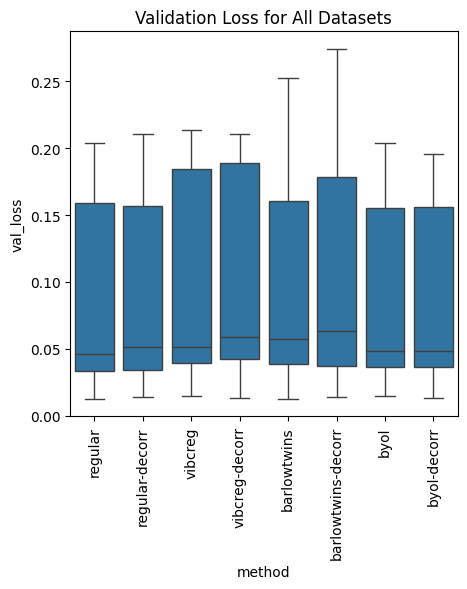

In [33]:
f, a = plt.subplots(len(datasets), 2, figsize=(10, 40))
for dataset in datasets:
    sns.boxplot(x="method", y="svm_accuracy", data=all_summaries_stage1[all_summaries_stage1["dataset"] == dataset], ax=a[datasets.index(dataset)][0])
    a[datasets.index(dataset)][0].set_title(f"SVM Accuracy for {dataset} - Stage 1")
    a[datasets.index(dataset)][0].set_xticklabels(a[datasets.index(dataset)][0].get_xticklabels(), rotation=45)  # Rotate x-axis labels
    sns.boxplot(x="method", y="knn_accuracy", data=all_summaries_stage1[all_summaries_stage1["dataset"] == dataset], ax=a[datasets.index(dataset)][1])
    a[datasets.index(dataset)][1].set_title(f"KNN Accuracy for {dataset} - Stage 2")
    a[datasets.index(dataset)][1].set_xticklabels(a[datasets.index(dataset)][1].get_xticklabels(), rotation=45)  # Rotate x-axis labels

plt.subplots_adjust(hspace = 1)  # Add more vertical spacing between subplots
plt.show()

plt.figure(figsize=(5, 5))
sns.boxplot(x="method", y="svm_accuracy", data=all_summaries_stage1)
plt.title("SVM Accuracy for All Datasets")
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(5, 5))
sns.boxplot(x="method", y="knn_accuracy", data=all_summaries_stage1)
plt.title("SVM Accuracy for All Datasets")
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(5, 5))
sns.boxplot(x="method", y="val_loss", data=all_summaries_stage1)
plt.title("Validation Loss for All Datasets")
plt.xticks(rotation=90)
plt.show()

/tmp/ipykernel_66701/1586685003.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a[datasets.index(dataset)][0].set_xticklabels(a[datasets.index(dataset)][0].get_xticklabels(), rotation=45)  # Rotate x-axis labels
/tmp/ipykernel_66701/1586685003.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a[datasets.index(dataset)][1].set_xticklabels(a[datasets.index(dataset)][1].get_xticklabels(), rotation=45)  # Rotate x-axis labels
/tmp/ipykernel_66701/1586685003.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a[datasets.index(dataset)][0].set_xticklabels(a[datasets.index(dataset)][0].get_xticklabels(), rotation=45)  # Rotate x-axis labels
/tmp/ipykernel_66701/1586685003.py:9: UserWarning: set_ticklabels() should only be used with a fixed

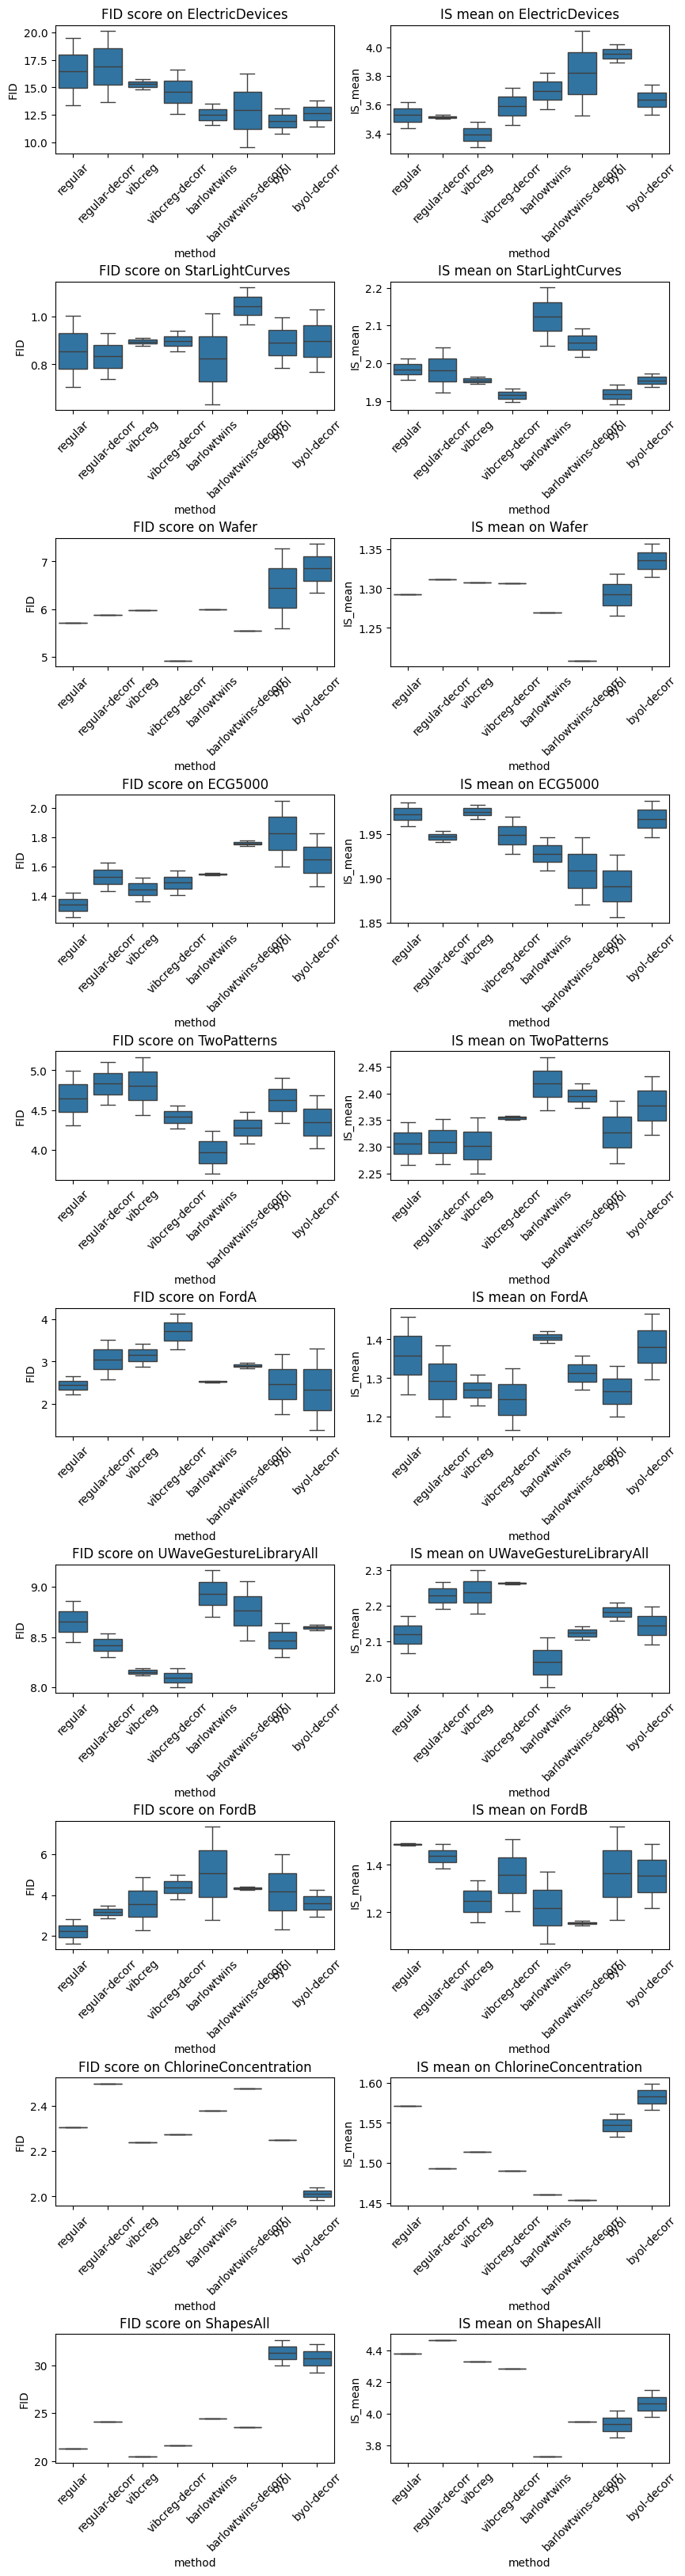

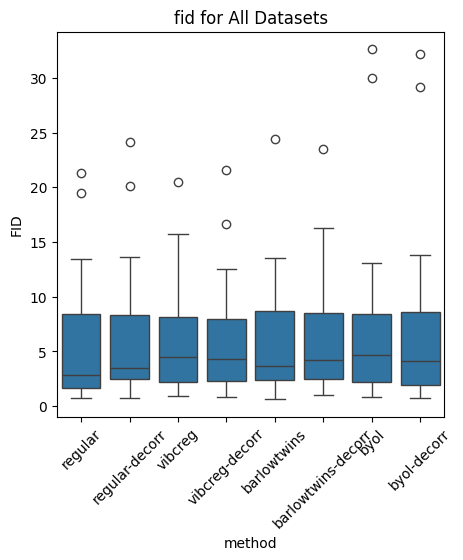

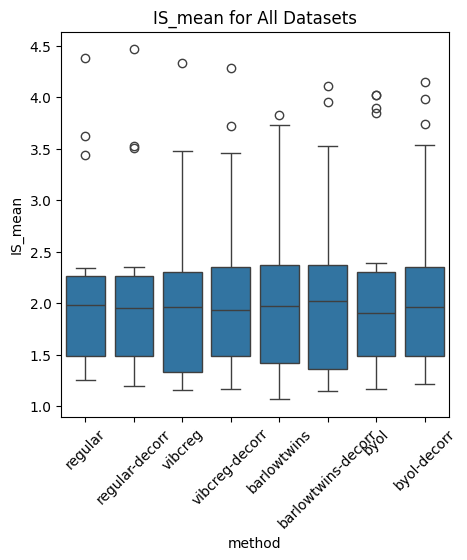

In [34]:
f, a = plt.subplots(len(datasets), 2, figsize=(10, 40))
for dataset in datasets:
    sns.boxplot(x="method", y="FID", data=all_summaries_stage2[all_summaries_stage2["dataset"] == dataset], ax=a[datasets.index(dataset)][0])
    a[datasets.index(dataset)][0].set_title(f"FID score on {dataset}")
    a[datasets.index(dataset)][0].set_xticklabels(a[datasets.index(dataset)][0].get_xticklabels(), rotation=45)  # Rotate x-axis labels

    sns.boxplot(x="method", y="IS_mean", data=all_summaries_stage2[all_summaries_stage2["dataset"] == dataset], ax=a[datasets.index(dataset)][1])
    a[datasets.index(dataset)][1].set_title(f"IS mean on {dataset}")
    a[datasets.index(dataset)][1].set_xticklabels(a[datasets.index(dataset)][1].get_xticklabels(), rotation=45)  # Rotate x-axis labels

plt.subplots_adjust(hspace = 1) 
plt.show()

plt.figure(figsize=(5, 5))
sns.boxplot(x="method", y="FID", data=all_summaries_stage2)
plt.title("fid for All Datasets")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(5, 5))
sns.boxplot(x="method", y="IS_mean", data=all_summaries_stage2)
plt.title("IS_mean for All Datasets")
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_66701/2983011233.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a[datasets.index(dataset)][0].set_xticklabels(a[datasets.index(dataset)][0].get_xticklabels(), rotation=45)  # Rotate x-axis labels
/tmp/ipykernel_66701/2983011233.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a[datasets.index(dataset)][1].set_xticklabels(a[datasets.index(dataset)][1].get_xticklabels(), rotation=45)  # Rotate x-axis labels
/tmp/ipykernel_66701/2983011233.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a[datasets.index(dataset)][0].set_xticklabels(a[datasets.index(dataset)][0].get_xticklabels(), rotation=45)  # Rotate x-axis labels
/tmp/ipykernel_66701/2983011233.py:15: UserWarning: set_ticklabels() should only be used with a f

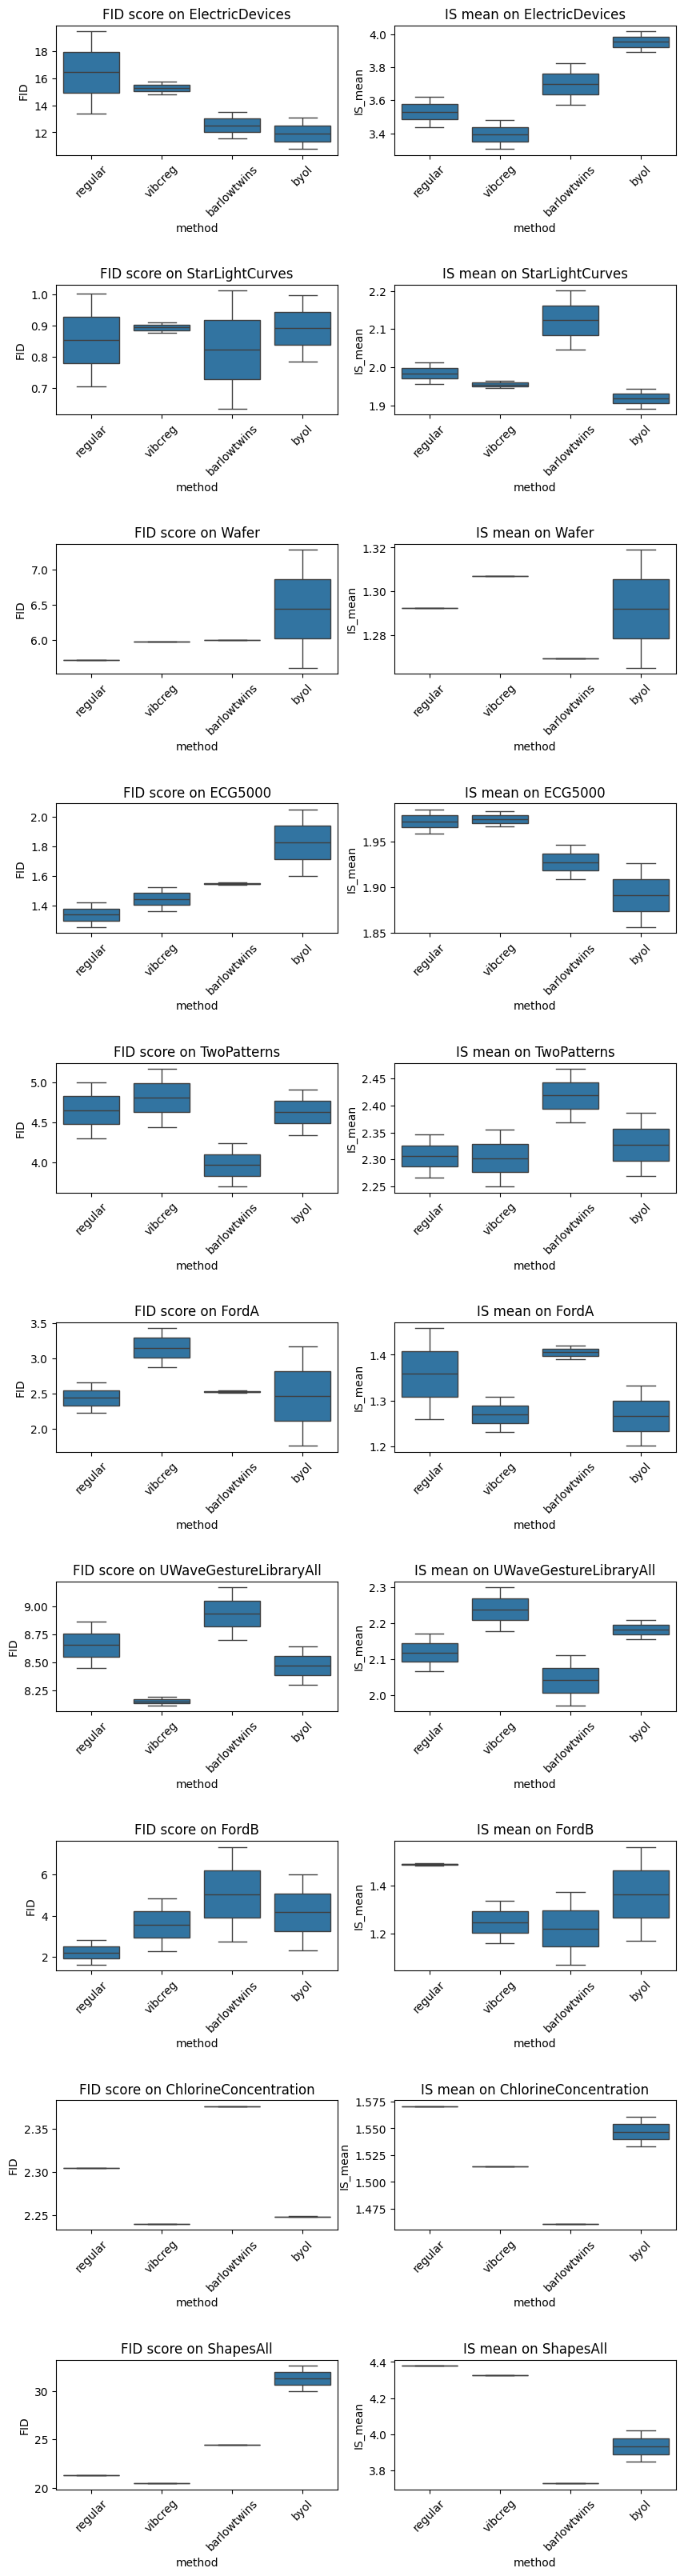

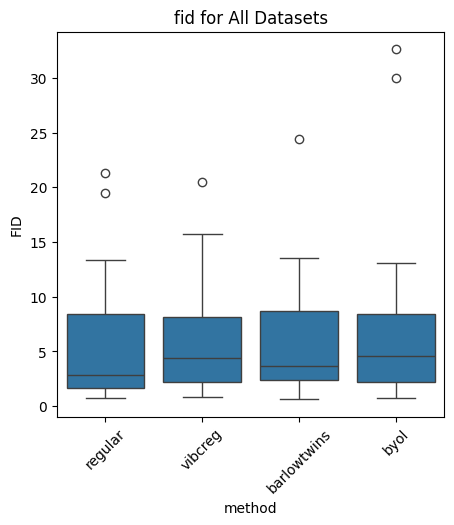

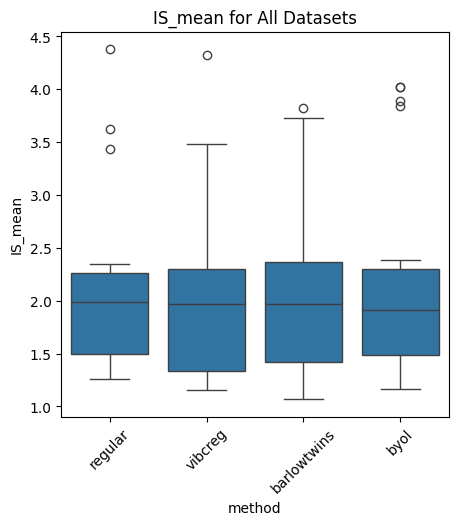

In [35]:
methods = ["regular", "vibcreg", "barlowtwins", "byol"]

# Filter the DataFrame to only include the specified methods
filtered_df = all_summaries_stage2[all_summaries_stage2['method'].isin(methods)]

f, a = plt.subplots(len(datasets), 2, figsize=(10, 40))

for dataset in datasets:
    sns.boxplot(x="method", y="FID", data=filtered_df[filtered_df["dataset"] == dataset], ax=a[datasets.index(dataset)][0])
    a[datasets.index(dataset)][0].set_title(f"FID score on {dataset}")
    a[datasets.index(dataset)][0].set_xticklabels(a[datasets.index(dataset)][0].get_xticklabels(), rotation=45)  # Rotate x-axis labels

    sns.boxplot(x="method", y="IS_mean", data=filtered_df[filtered_df["dataset"] == dataset], ax=a[datasets.index(dataset)][1])
    a[datasets.index(dataset)][1].set_title(f"IS mean on {dataset}")
    a[datasets.index(dataset)][1].set_xticklabels(a[datasets.index(dataset)][1].get_xticklabels(), rotation=45)  # Rotate x-axis labels

plt.subplots_adjust(hspace = 1)  # Add more vertical spacing between subplots
plt.show()

plt.figure(figsize=(5, 5))
sns.boxplot(x="method", y="FID", data=filtered_df)
plt.title("fid for All Datasets")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(5, 5))
sns.boxplot(x="method", y="IS_mean", data=filtered_df)
plt.title("IS_mean for All Datasets")
plt.xticks(rotation=45)
plt.show()